This notebook aims to exploring what simple models can achieve in this competition.

In doing so, we want to correctly implement cross-validation techniques and try to explain what our models are telling us.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import RobustScaler

import statsmodels.api as sm

%matplotlib inline
pd.set_option('max_columns', 500)

## A first look at the available data

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


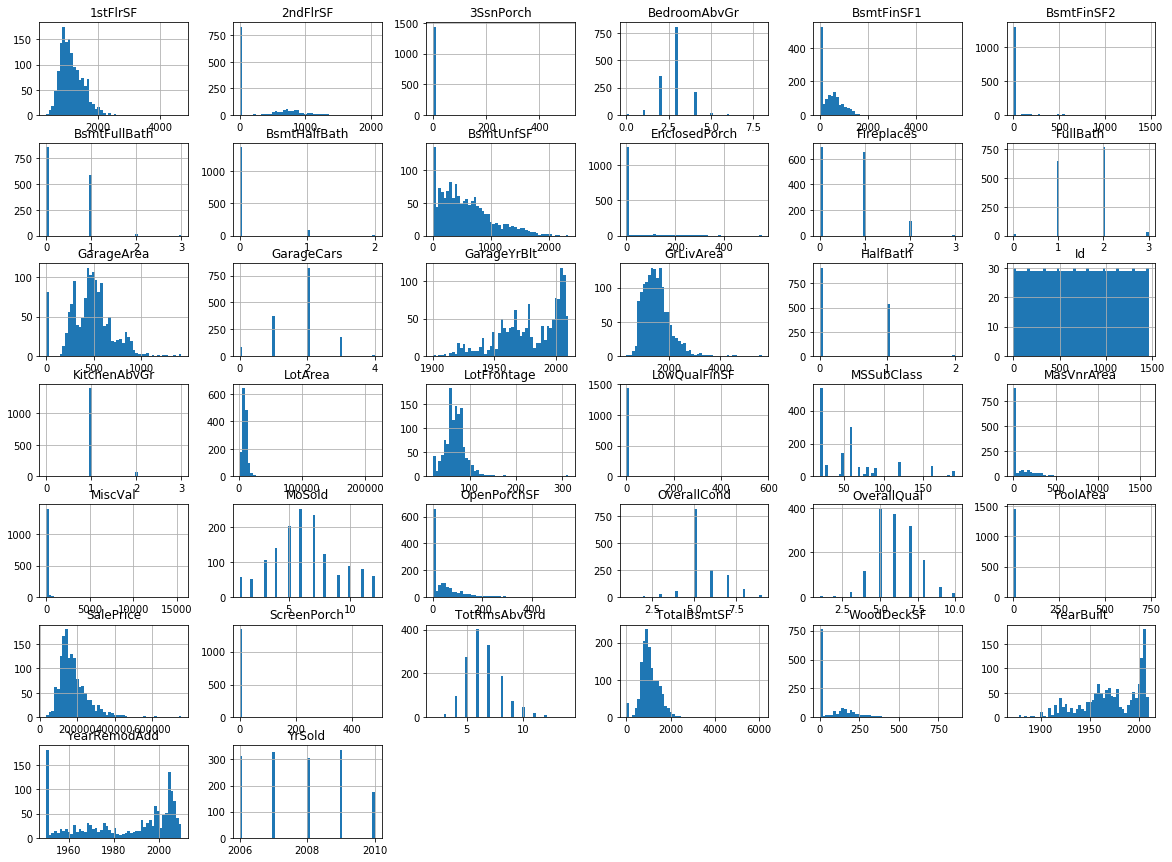

In [5]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

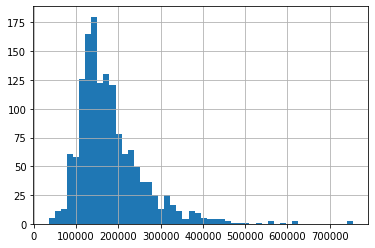

In [6]:
df_train.SalePrice.hist(bins=50)

## Create a test set

To correctly evaluate our models, we need a dataset that correcly represents the data we have. One way to achieve that is to explore quickly the role of some features.

Let's see if some neighborhoods have a different price distribution

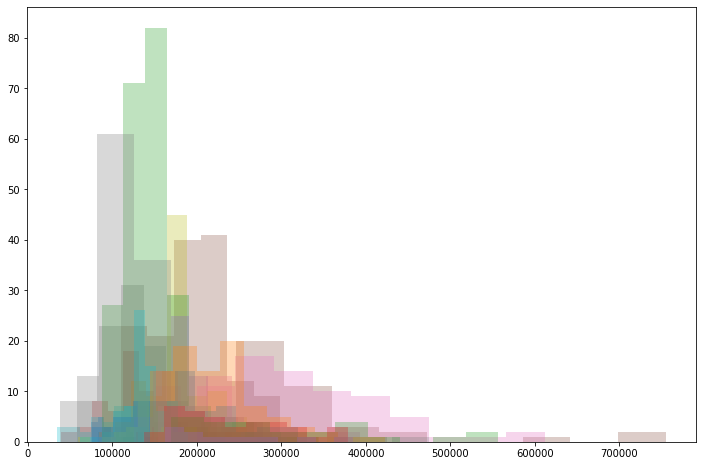

In [7]:
df_train.groupby('Neighborhood').SalePrice.hist(bins=10, alpha=0.3, figsize=(12,8))
plt.grid(False)
plt.show()

In [8]:
df_train.groupby('Neighborhood')[['SalePrice', 
                                  'GrLivArea', 
                                  'YearBuilt']].agg(['mean', 
                                                     'median', 
                                                     'std']).sort_values(('SalePrice', 
                                                                          'median'), ascending=False)

SalePrice                           GrLivArea          \
                       mean  median            std         mean  median   
Neighborhood                                                              
NridgHt       316270.623377  315000   96392.544954  1915.948052  1850.0   
NoRidge       335295.317073  301500  121412.658640  2508.853659  2418.0   
StoneBr       310499.000000  278000  112969.676640  1879.080000  1742.0   
Timber        242247.447368  228475   64845.651549  1749.368421  1689.5   
Somerst       225379.837209  225500   56177.555888  1596.651163  1564.5   
Veenker       238772.727273  218000   72369.317959  1539.636364  1437.0   
Crawfor       210624.725490  200624   68866.395472  1791.607843  1717.0   
ClearCr       212565.428571  200250   50231.538993  1788.107143  1738.0   
CollgCr       197965.773333  197200   51403.666438  1480.500000  1500.0   
Blmngtn       194870.882353  191000   30393.229219  1427.941176  1500.0   
NWAmes        189050.068493  182900   37172.218106  1727.780822  1664.0   
Gilbert       192854.506329  181000   35986.779085  1641.316456  1593.0   
SawyerW       186555.796610  179900   55651.997820  1595.016949  1603.0   
Mitchel       156270.122449  153500   36486.625334  1294.204082  1204.0   
NPkVill       142694.444444  146000    9377.314529  1253.000000  1322.0   
NAmes         145847.080000  140000   33075.345450  1310.311111  1200.0   
SWISU         142591.360000  139500   32622.917679  1801.240000  1691.0   
Blueste       137500.000000  137500   19091.883092  1392.500000  1392.5   
Sawyer        136793.135135  135000   22345.129157  1215.135135  1106.0   
BrkSide       124834.051724  124300   40348.689270  1203.068966  1210.5   
Edwards       128219.700000  121750   43208.616459  1340.040000  1200.0   
OldTown       128225.300885  119000   52650.583185  1479.725664  1374.0   
BrDale        104493.750000  106000   14330.176493  1143.187500  1155.0   
IDOTRR        100123.783784  103000   33376.710117  1142.297297  1128.0   
MeadowV        98576.470588   88000   23491.049610  1058.941176  1092.0   

                            YearBuilt                     
                     std         mean  median        std  
Neighborhood                                              
NridgHt       427.228057  2005.675325  2006.0   1.802349  
NoRidge       592.063618  1995.439024  1995.0   2.674404  
StoneBr       570.728987  1998.480000  2001.0   9.065135  
Timber        391.576124  1992.842105  2002.0  17.033395  
Somerst       294.937432  2004.988372  2006.0   3.122948  
Veenker       313.984481  1982.363636  1978.0   8.381798  
Crawfor       544.549101  1941.549020  1938.0  23.425041  
ClearCr       467.243718  1966.571429  1966.5  19.305399  
CollgCr       430.932464  1997.886667  2002.0  10.436472  
Blmngtn       138.178087  2005.235294  2005.0   1.251470  
NWAmes        416.360196  1975.630137  1976.0   6.703040  
Gilbert       297.675763  1998.253165  2000.0  10.508200  
SawyerW       507.988375  1988.559322  1991.0  13.169022  
Mitchel       377.581006  1981.755102  1982.0  14.724598  
NPkVill       237.515789  1976.444444  1976.0   1.236033  
NAmes         413.498252  1959.995556  1960.0   8.770638  
SWISU         632.355667  1925.240000  1925.0   9.270383  
Blueste       231.223917  1980.000000  1980.0   0.000000  
Sawyer        344.624883  1963.675676  1965.0  14.071353  
BrkSide       386.614222  1931.431034  1929.5  11.941542  
Edwards       655.209920  1955.970000  1954.0  28.865573  
OldTown       576.943613  1922.884956  1920.0  23.095590  
BrDale        155.828632  1971.437500  1971.0   1.030776  
IDOTRR        283.902357  1927.945946  1922.0  13.144382  
MeadowV       472.625839  1972.588235  1972.0   2.670647

Neighborhood seems quite an important feature. Let's create a test that correctly represents the distribution of houses across neighborhoods

In [9]:
df_train['Neighborhood'].value_counts() / len(df_train)

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
SWISU      0.017123
StoneBr    0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

In [10]:
def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

In [11]:
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

In [12]:
train_set['Neighborhood'].value_counts() / len(train_set)

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077055
Edwards    0.068493
Somerst    0.059075
Gilbert    0.053938
NridgHt    0.053082
Sawyer     0.050514
NWAmes     0.049658
SawyerW    0.040240
BrkSide    0.039384
Crawfor    0.035103
Mitchel    0.033390
NoRidge    0.028253
Timber     0.025685
IDOTRR     0.025685
ClearCr    0.018836
SWISU      0.017123
StoneBr    0.017123
Blmngtn    0.011986
MeadowV    0.011986
BrDale     0.011130
Veenker    0.007705
NPkVill    0.005993
Blueste    0.001712
Name: Neighborhood, dtype: float64

In [13]:
test_set['Neighborhood'].value_counts() / len(test_set)

NAmes      0.154110
CollgCr    0.102740
OldTown    0.078767
Edwards    0.068493
Somerst    0.058219
Gilbert    0.054795
NWAmes     0.051370
Sawyer     0.051370
NridgHt    0.051370
SawyerW    0.041096
BrkSide    0.041096
Crawfor    0.034247
Mitchel    0.034247
Timber     0.027397
NoRidge    0.027397
IDOTRR     0.023973
ClearCr    0.020548
StoneBr    0.017123
SWISU      0.017123
Blmngtn    0.010274
BrDale     0.010274
MeadowV    0.010274
NPkVill    0.006849
Veenker    0.006849
Name: Neighborhood, dtype: float64

We thus have train and a test sets that correcly represent the distribution of houses across neighborhoods.

# A couple of very simple models

The simplest model we can do is one that just predicts every price as the median price in the training set.

In [14]:
median_price = train_set.SalePrice.median()
median_price

164700.0

In [15]:
def print_scores(train, test, inf, oof):
    print(f'Train set RMSE: {mean_squared_error(train.SalePrice, inf)}')
    print(f'Test set RMSE: {mean_squared_error(test.SalePrice, oof)}')
    print(f'Train set logRMSE: {mean_squared_log_error(train.SalePrice, inf)}')
    print(f'Test set logRMSE: {mean_squared_log_error(test.SalePrice, oof)}')
    print(f'Train set MAE: {mean_absolute_error(train.SalePrice, inf)}')
    print(f'Test set MAE: {mean_absolute_error(test.SalePrice, oof)}')
    
    
def plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax

    
def plot_predictions(train, test, true_label, pred_label, hue=None, legend=False):
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))

    sns.scatterplot(x=true_label, y=pred_label, data=train, 
                    hue=hue, ax=ax[0], legend=legend, alpha=0.7)
    sns.scatterplot(x=true_label, y=pred_label, data=test, 
                    hue=hue, ax=ax[1], legend=legend, alpha=0.7)
    ax[0].set_title('In fold prediction')
    ax[1].set_title('Oof prediction')
    
    ax[0] = plot_diagonal(ax[0])
    ax[1] = plot_diagonal(ax[1])


In [16]:
print_scores(train_set, test_set, [median_price]*len(train_set), [median_price]*len(test_set))

Train set RMSE: 6742914458.577055
Test set RMSE: 5877921073.013699
Train set logRMSE: 0.16109448860248418
Test set logRMSE: 0.1536148120235167
Train set MAE: 56331.13356164384
Test set MAE: 52410.938356164384


In [17]:
def make_sub(df_test, prediction, filename):
    sub = df_test[['Id']].copy()
    sub['SalePrice'] = prediction
    sub.to_csv('../submissions/'+filename, index=False)

In [18]:
make_sub(df_test, [median_price] * len(df_test), 'baseline_median.csv')

This model is very underfitting and, most importantly, is missing the price on average by about 52k dollars. Not really a great start.

Since we use Neighborhood as a feature important enough to split our data based on it, maybe by using it to predict the median price we get a better score.

Let's thus calculate the median price by Neighborhood.

In [19]:
median_price = train_set.groupby('Neighborhood', as_index=False)['SalePrice'].median()

median_price.rename(columns={'SalePrice': 'Prediction'}, inplace=True)

median_price

,Neighborhood,Prediction
0,Blmngtn,186500
1,Blueste,137500
2,BrDale,100000
3,BrkSide,121300
4,ClearCr,218000
5,CollgCr,201750
6,Crawfor,217500
7,Edwards,119500
8,Gilbert,181000
9,IDOTRR,107250


In [20]:
train_sub = pd.merge(train_set[['Neighborhood', 'SalePrice']], median_price, 
                     on='Neighborhood', how='left', validate='m:1')


test_sub = pd.merge(test_set[['Neighborhood', 'SalePrice']], median_price, 
                     on='Neighborhood', how='left', validate='m:1')

In [21]:
print_scores(train_sub, test_sub, train_sub.Prediction, test_sub.Prediction)

Train set RMSE: 3116099653.183219
Test set RMSE: 2554014064.537671
Train set logRMSE: 0.07188539270711183
Test set logRMSE: 0.06529080998450065
Train set MAE: 35580.31506849315
Test set MAE: 34516.75684931507


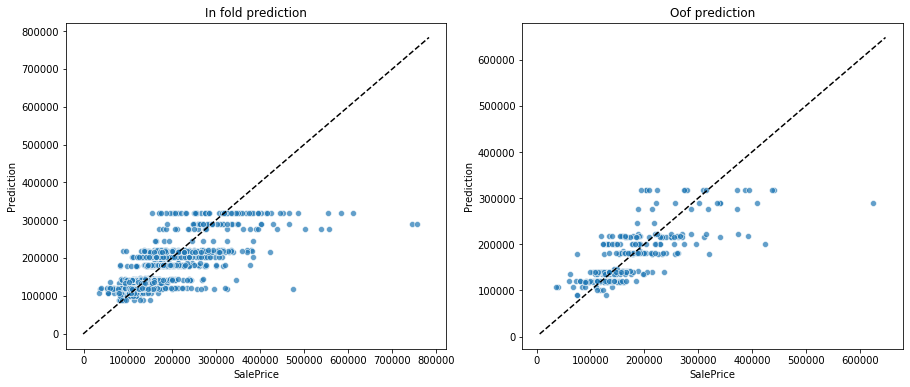

In [22]:
plot_predictions(train_sub, test_sub, true_label='SalePrice', pred_label='Prediction')

As we can see, our model predicts *in levels*, as it is expected by a model that uses one value for each neighborhood.

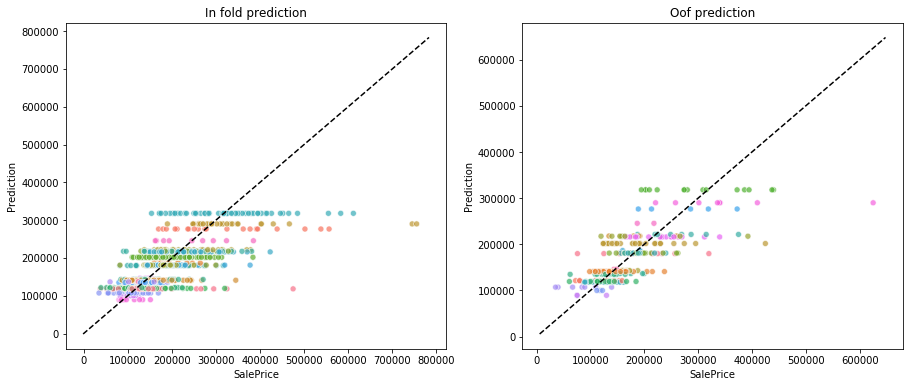

In [23]:
plot_predictions(train_sub, test_sub, 
                 true_label='SalePrice', pred_label='Prediction', hue='Neighborhood')

In [24]:
submission = pd.merge(df_test[['Id', 'Neighborhood']], median_price, 
                      on='Neighborhood', how='left', validate='m:1')
submission = submission.Prediction

make_sub(df_test, submission, 'baseline_by_nn.csv')

With this simple approach, we improved our baseline model and obtain predictions that are about 50% better than before (meaning that our mean absolute error dropped by 25k, give or take), not bad.

The next step is to try to use what we could expect a good predictor: GrLivArea. I want to experiment what happens if we use a regression for each neighborhood.

In [25]:
def regress(data, yvar, xvars):
    Y = data[yvar].copy()
    X = data[xvars].copy()
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_by(data, xvars, cat_var, target):
    xvars = xvars + ['intercept']
    trained_models = data.groupby(cat_var)[[target] + xvars].agg(regress,
                                                               target,
                                                               xvars)[xvars]
    return trained_models

In [26]:
to_group = train_set.copy()
to_group['intercept'] = 1

liv_area = regress_by(to_group, ['GrLivArea'], 
                      cat_var='Neighborhood', target='SalePrice').reset_index()

liv_area.rename(columns={'GrLivArea': 'coef_GLA'}, inplace=True)

liv_area

,Neighborhood,coef_GLA,intercept
0,Blmngtn,130.262344,12191.160212
1,Blueste,82.568807,22522.935780
2,BrDale,55.585664,39894.840668
3,BrkSide,89.264093,16470.849812
4,ClearCr,26.944813,169421.947401
5,CollgCr,97.997290,53491.862604
6,Crawfor,84.152235,58381.266073
7,Edwards,34.847110,83344.149242
8,Gilbert,71.427883,76585.914981
9,IDOTRR,74.373178,17099.173181


We see how in every Neighborhood a bigger house will cost more. However, we observe also that some neighborhoods already have a quite high base price.

In [27]:
train_sub = pd.merge(train_set[['Neighborhood', 'SalePrice', 'GrLivArea']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

train_sub['Prediction'] = train_sub.intercept + train_sub.GrLivArea * train_sub.coef_GLA

train_sub.head()

,Neighborhood,SalePrice,GrLivArea,coef_GLA,intercept,Prediction
0,OldTown,80000,747,69.313363,25394.196442,77171.278846
1,StoneBr,170000,1088,158.781506,9928.524234,182682.802277
2,Blmngtn,167240,1248,130.262344,12191.160212,174758.565163
3,NAmes,153000,1306,55.663370,72770.603893,145466.965653
4,OldTown,124500,1960,69.313363,25394.196442,161248.388560


In [28]:
test_sub = pd.merge(test_set[['Neighborhood', 'SalePrice', 'GrLivArea']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

test_sub['Prediction'] = test_sub.intercept + test_sub.GrLivArea * test_sub.coef_GLA

test_sub.head()

,Neighborhood,SalePrice,GrLivArea,coef_GLA,intercept,Prediction
0,SawyerW,233000,2084,90.562663,42213.672005,230946.262470
1,SawyerW,179200,1575,90.562663,42213.672005,184849.866814
2,BrkSide,127000,1252,89.264093,16470.849812,128229.494215
3,NAmes,129000,864,55.663370,72770.603893,120863.755930
4,ClearCr,192000,2022,26.944813,169421.947401,223904.358667


In [29]:
print_scores(train_sub, test_sub, train_sub.Prediction, test_sub.Prediction)

Train set RMSE: 1326704097.649271
Test set RMSE: 1089479280.5808673
Train set logRMSE: 0.03546894972259115
Test set logRMSE: 0.03609861041852865
Train set MAE: 25413.23964985295
Test set MAE: 22726.212937269727


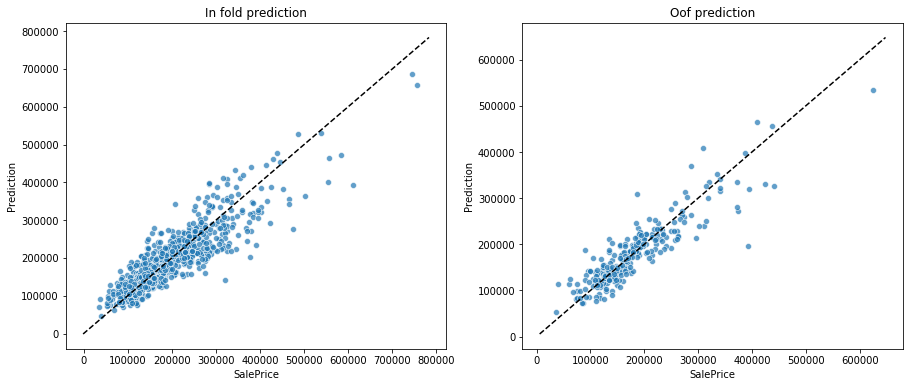

In [30]:
plot_predictions(train_sub, test_sub, true_label='SalePrice', pred_label='Prediction')

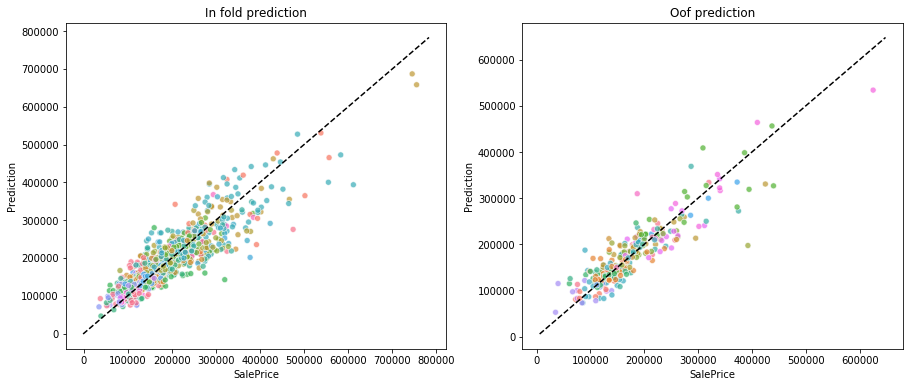

In [31]:
plot_predictions(train_sub, test_sub, 
                 true_label='SalePrice', pred_label='Prediction', hue='Neighborhood')

In [32]:
submission = pd.merge(df_test[['Id', 'Neighborhood', 'GrLivArea']], liv_area, 
                      on='Neighborhood', how='left', validate='m:1')

submission = submission.intercept + submission.GrLivArea * submission.coef_GLA

make_sub(df_test, submission, 'linear_by_nn.csv')

Much better again, 10k more accurate than before. One could already argue that this is good enough for a business case, being 20k a good *negotiation margin* for a house.

We noticed at the beginning that different neighborhoods have houses built in different decades, we can try to include this into the model too.

In [33]:
to_group = train_set.copy()
to_group['intercept'] = 1

liv_area = regress_by(to_group, ['GrLivArea', 'YearBuilt'],
                     cat_var='Neighborhood', target='SalePrice').reset_index()

liv_area.rename(columns={'GrLivArea': 'coef_GLA', 'YearBuilt': 'coef_YB'}, inplace=True)

liv_area

,Neighborhood,coef_GLA,coef_YB,intercept
0,Blmngtn,141.093854,-6697.205934,1.342561e+07
1,Blueste,82.568807,11.375217,5.745059e-03
2,BrDale,57.998645,1006.831701,-1.947709e+06
3,BrkSide,83.882683,-763.729228,1.497154e+06
4,ClearCr,32.128757,303.382502,-4.366658e+05
5,CollgCr,87.157727,916.308333,-1.761487e+06
6,Crawfor,81.857550,863.712890,-1.613299e+06
7,Edwards,27.603513,574.113004,-1.029636e+06
8,Gilbert,65.968995,937.315827,-1.786805e+06
9,IDOTRR,76.575045,347.416168,-6.548126e+05


In [34]:
train_sub = pd.merge(train_set[['Neighborhood', 'SalePrice', 'GrLivArea', 'YearBuilt']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

train_sub['Prediction'] = train_sub.intercept + train_sub.GrLivArea * train_sub.coef_GLA + train_sub.YearBuilt * train_sub.coef_YB

train_sub.head()

,Neighborhood,SalePrice,GrLivArea,YearBuilt,coef_GLA,coef_YB,intercept,Prediction
0,OldTown,80000,747,1945,80.309429,544.233167,-1.036841e+06,81683.212121
1,StoneBr,170000,1088,1986,112.237865,5966.902321,-1.182101e+07,151373.270126
2,Blmngtn,167240,1248,2005,141.093854,-6697.205934,1.342561e+07,173798.131603
3,NAmes,153000,1306,1957,56.901451,1006.303799,-1.901628e+06,142021.569001
4,OldTown,124500,1960,1952,80.309429,544.233167,-1.036841e+06,182908.181263


In [35]:
test_sub = pd.merge(test_set[['Neighborhood', 'SalePrice', 'GrLivArea', 'YearBuilt']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

test_sub['Prediction'] = test_sub.intercept + test_sub.GrLivArea * test_sub.coef_GLA + test_sub.YearBuilt * test_sub.coef_YB

test_sub.head()

,Neighborhood,SalePrice,GrLivArea,YearBuilt,coef_GLA,coef_YB,intercept,Prediction
0,SawyerW,233000,2084,2004,86.448509,1151.321925,-2.241314e+06,246093.712681
1,SawyerW,179200,1575,1992,86.448509,1151.321925,-2.241314e+06,188275.558717
2,BrkSide,127000,1252,1908,83.882683,-763.729228,1.497154e+06,144979.791424
3,NAmes,129000,864,1950,56.901451,1006.303799,-1.901628e+06,109827.001121
4,ClearCr,192000,2022,1977,32.128757,303.382502,-4.366658e+05,228085.763127


In [36]:
print_scores(train_sub, test_sub, train_sub.Prediction, test_sub.Prediction)

Train set RMSE: 1087838054.7836432
Test set RMSE: 951647481.0543039
Train set logRMSE: 0.029910216284557374
Test set logRMSE: 0.033161426797475003
Train set MAE: 22670.779296163775
Test set MAE: 21614.532846562648


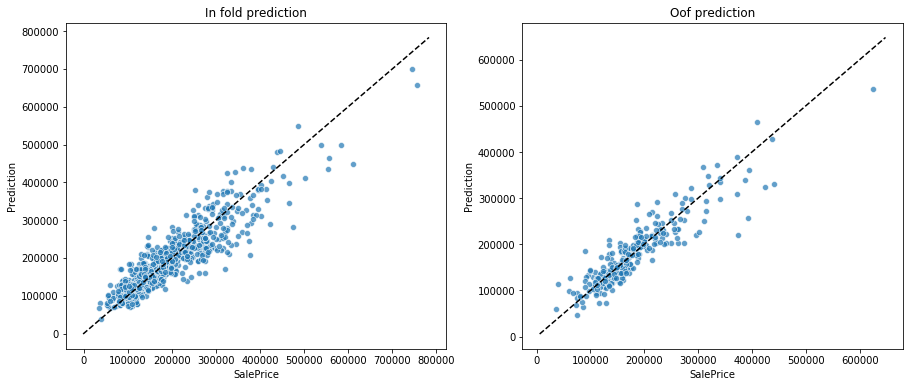

In [37]:
plot_predictions(train_sub, test_sub, true_label='SalePrice', pred_label='Prediction')

In [38]:
submission = pd.merge(df_test[['Id', 'Neighborhood', 'GrLivArea', 'YearBuilt']], liv_area, 
                      on='Neighborhood', how='left', validate='m:1')

submission = submission.intercept + submission.GrLivArea * submission.coef_GLA + submission.YearBuilt * submission.coef_YB

make_sub(df_test, submission, 'linear_by_nn_yr.csv')

A little bit better, but no game changer.

## Some improvements

We saw that the target is skewed, we can take care of that by predicting the logarithm of it.

Moreover, our last model put together living area and year built. These 2 features have very different scales, making the model less interpretable.

The one thing to be mindful of here is that we need to fit our scaler only on the training set or we risk of compromising our cross-validation score.

In [39]:
train_set['target'] = np.log1p(train_set.SalePrice)
test_set['target'] = np.log1p(test_set.SalePrice)

scl = RobustScaler().fit(train_set[['GrLivArea', 'YearBuilt']])

scl_train = scl.transform(train_set[['GrLivArea', 'YearBuilt']])
scl_train = pd.DataFrame(scl_train, columns=['GrLivArea', 'YearBuilt'])
scl_train['Neighborhood'] = train_set.reset_index().Neighborhood
scl_train['SalePrice'] = train_set.reset_index().target

scl_test = scl.transform(test_set[['GrLivArea', 'YearBuilt']])
scl_test = pd.DataFrame(scl_test, columns=['GrLivArea', 'YearBuilt'])
scl_test['Neighborhood'] = test_set.reset_index().Neighborhood
scl_test['SalePrice'] = test_set.reset_index().target

scl_train.head()

,GrLivArea,YearBuilt,Neighborhood,SalePrice
0,-1.101328,-0.605405,OldTown,11.289794
1,-0.583681,0.281081,StoneBr,12.043560
2,-0.340797,0.691892,Blmngtn,12.027191
3,-0.252751,-0.345946,NAmes,11.938200
4,0.740038,-0.454054,OldTown,11.732069


In [40]:
to_group = scl_train.copy()
to_group['intercept'] = 1

liv_area = regress_by(to_group, ['GrLivArea', 'YearBuilt'],
                     cat_var='Neighborhood', target='SalePrice').reset_index()

liv_area.rename(columns={'GrLivArea': 'coef_GLA', 'YearBuilt': 'coef_YB'}, inplace=True)

liv_area

,Neighborhood,coef_GLA,coef_YB,intercept
0,Blmngtn,0.463179,-1.653845,13.366359
1,Blueste,0.396855,1.757009,11.608813
2,BrDale,0.367759,0.432602,11.736670
3,BrkSide,0.471369,-0.273747,11.604484
4,ClearCr,0.106764,0.057098,12.219176
5,CollgCr,0.283016,0.302694,12.000127
6,Crawfor,0.257509,0.221624,12.235441
7,Edwards,0.126709,0.211598,11.825260
8,Gilbert,0.207950,0.224779,11.986430
9,IDOTRR,0.531446,0.138547,11.882717


In [41]:
train_sub = pd.merge(scl_train[['Neighborhood', 'SalePrice', 'GrLivArea', 'YearBuilt']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

train_sub['Prediction'] = train_sub.intercept + train_sub.GrLivArea * train_sub.coef_GLA + train_sub.YearBuilt * train_sub.coef_YB

train_sub.SalePrice = np.expm1(train_sub.SalePrice)
train_sub.Prediction = np.expm1(train_sub.Prediction)

train_sub.head()

,Neighborhood,SalePrice,GrLivArea,YearBuilt,coef_GLA,coef_YB,intercept,Prediction
0,OldTown,80000.0,-1.101328,-0.605405,0.319430,0.180677,11.892707,92181.567776
1,StoneBr,170000.0,-0.583681,0.281081,0.207584,0.981236,11.928627,176886.863623
2,Blmngtn,167240.0,-0.340797,0.691892,0.463179,-1.653845,13.366359,173550.016231
3,NAmes,153000.0,-0.252751,-0.345946,0.223857,0.292404,12.000973,139139.131785
4,OldTown,124500.0,0.740038,-0.454054,0.319430,0.180677,11.892707,170596.136037


In [42]:
test_sub = pd.merge(scl_test[['Neighborhood', 'SalePrice', 'GrLivArea', 'YearBuilt']], liv_area, 
                     on='Neighborhood', how='left', validate='m:1')

test_sub['Prediction'] = test_sub.intercept + test_sub.GrLivArea * test_sub.coef_GLA + test_sub.YearBuilt * test_sub.coef_YB
test_sub.SalePrice = np.expm1(test_sub.SalePrice)
test_sub.Prediction = np.expm1(test_sub.Prediction)

test_sub.head()

,Neighborhood,SalePrice,GrLivArea,YearBuilt,coef_GLA,coef_YB,intercept,Prediction
0,SawyerW,233000.0,0.928273,0.670270,0.300686,0.449887,11.882092,258526.502657
1,SawyerW,179200.0,0.155598,0.410811,0.300686,0.449887,11.882092,182351.511776
2,BrkSide,127000.0,-0.334725,-1.405405,0.471369,-0.273747,11.604484,137506.109285
3,NAmes,129000.0,-0.923719,-0.497297,0.223857,0.292404,12.000973,114550.523484
4,ClearCr,192000.0,0.834156,0.086486,0.106764,0.057098,12.219176,222608.035503


In [43]:
print_scores(train_sub, test_sub, train_sub.Prediction, test_sub.Prediction)

Train set RMSE: 1094797752.7383127
Test set RMSE: 964446590.0218192
Train set logRMSE: 0.029204306522375326
Test set logRMSE: 0.030816815172222022
Train set MAE: 22467.45956886425
Test set MAE: 21520.969233337193


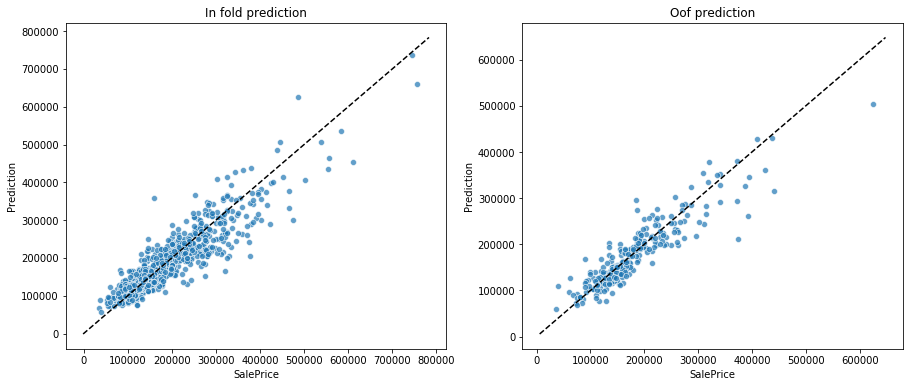

In [44]:
plot_predictions(train_sub, test_sub, true_label='SalePrice', pred_label='Prediction')